### Imports and magics

In [1]:
from fastai.vision import *

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

### Set paths

In [4]:
path = Path('.')
data_path = path/'data'

In [5]:
data_path.ls()

[PosixPath('data/wallmasks'),
 PosixPath('data/images'),
 PosixPath('data/walllabels')]

In [6]:
image_path = data_path/'images'
mask_path = data_path/'walllabels'

### Check contents

In [7]:
print(len(image_path.ls()))
print(len(mask_path.ls()))

123
122


In [8]:
image_path.ls()[0:5]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png'),
 PosixPath('data/images/P109_000_000.png'),
 PosixPath('data/images/P033_000_000.png')]

In [9]:
mask_path.ls()[0:5]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png'),
 PosixPath('data/walllabels/P109_000_000.png'),
 PosixPath('data/walllabels/P033_000_000.png')]

### Create lists

In [10]:
image_list = get_image_files(image_path)
type(image_list)

list

In [11]:
image_list[0:5]

[PosixPath('data/images/P060_000_000.png'),
 PosixPath('data/images/P113_000_000.png'),
 PosixPath('data/images/P002_000_000.png'),
 PosixPath('data/images/P109_000_000.png'),
 PosixPath('data/images/P033_000_000.png')]

In [12]:
mask_list = get_image_files(mask_path)

In [13]:
mask_list[0:5]

[PosixPath('data/walllabels/P060_000_000.png'),
 PosixPath('data/walllabels/P113_000_000.png'),
 PosixPath('data/walllabels/P002_000_000.png'),
 PosixPath('data/walllabels/P109_000_000.png'),
 PosixPath('data/walllabels/P033_000_000.png')]

### View file contents

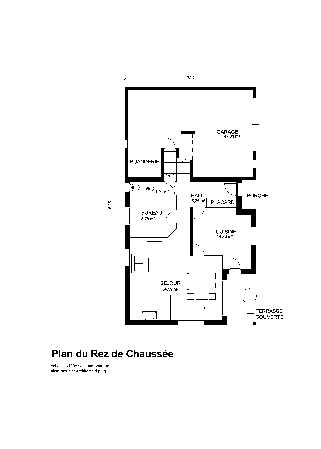

In [14]:
open_image(image_list[0]).show(figsize=(8,8))

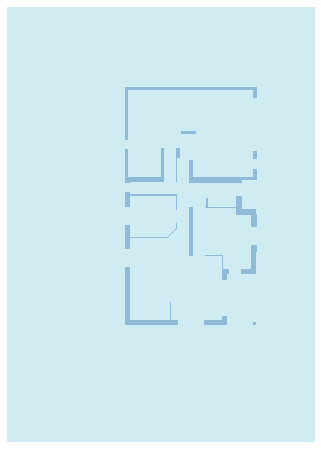

In [15]:
open_mask(mask_list[0]).show(figsize=(8,8))

In [16]:
#mask is rank 3 tensor
sample_mask = open_mask(mask_list[0])
sample_mask.shape

torch.Size([1, 3508, 2479])

### Create fastai data object with all data

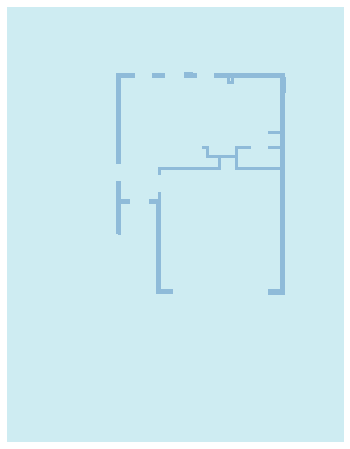

In [17]:
#to begin we need a way to tell the learner how to find the masks
#we can pass it a function which goes from image file to mask

path_func_image_to_mask = lambda x: mask_path/f'{x.stem}{x.suffix}'

#let test it, should return a mask
retrieved_mask = path_func_image_to_mask(image_list[120])
open_mask(retrieved_mask).show(figsize=(8,8))

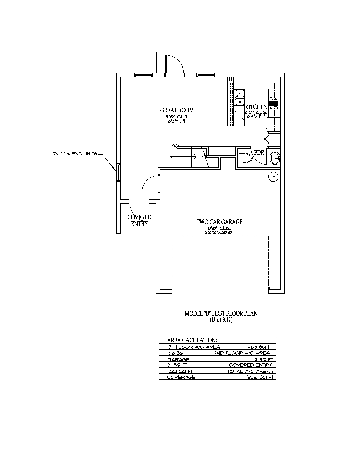

In [18]:
open_image(image_list[120]).show(figsize=(8,8))

In [19]:
seg_list = (SegmentationItemList
            .from_folder(image_path)
            .split_by_rand_pct(0.3, seed=99)
            .label_from_func(path_func_image_to_mask, classes=['wall', 'notawall'])
           )

In [20]:
print(type(seg_list), '\n', '_ '*20, '\n')
seg_list

<class 'fastai.data_block.LabelLists'> 
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  



LabelLists;

Train: LabelList (86 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 7383, 5671),Image (3, 1867, 1950),Image (3, 7383, 5671),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 7383, 5671),ImageSegment (1, 1867, 1950),ImageSegment (1, 7383, 5671),ImageSegment (1, 3508, 2479)
Path: data/images;

Valid: LabelList (36 items)
x: SegmentationItemList
Image (3, 3508, 2479),Image (3, 3508, 2480),Image (3, 3300, 2550),Image (3, 2480, 3508),Image (3, 3508, 2479)
y: SegmentationLabelList
ImageSegment (1, 3508, 2479),ImageSegment (1, 3508, 2480),ImageSegment (1, 3300, 2550),ImageSegment (1, 2480, 3508),ImageSegment (1, 3508, 2479)
Path: data/images;

Test: None

In [21]:
tfms = get_transforms()
type(tfms)


tuple

In [22]:
databunch = seg_list.transform(tfms, size=500, tfm_y=True).databunch(bs=4).normalize(imagenet_stats)
type(databunch)


fastai.vision.data.ImageDataBunch

In [23]:
databunch

ImageDataBunch;

Train: LabelList (86 items)
x: SegmentationItemList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: SegmentationLabelList
ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500)
Path: data/images;

Valid: LabelList (36 items)
x: SegmentationItemList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: SegmentationLabelList
ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500),ImageSegment (1, 500, 500)
Path: data/images;

Test: None

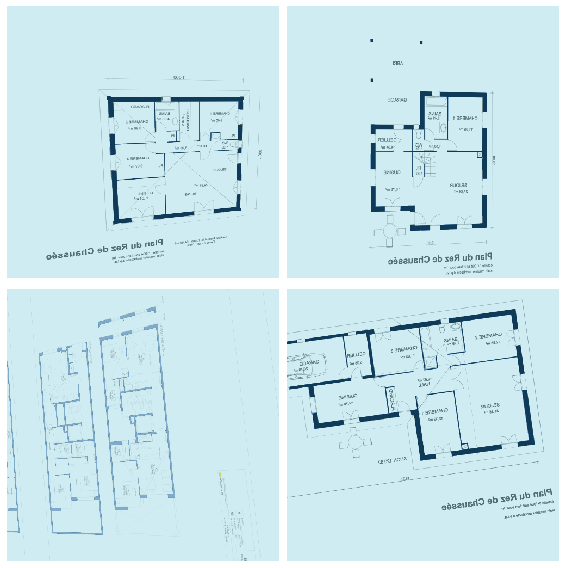

In [24]:
databunch.show_batch(2, figsize=(8,8))

### Create model

In [25]:
#weight decay
wd=1e-2




In [26]:
learner = unet_learner(databunch, models.resnet34, metrics=dice, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


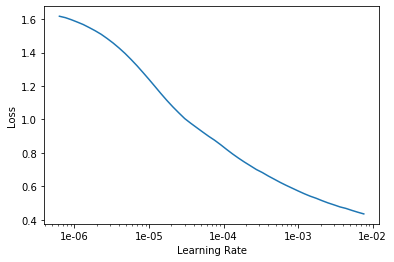

In [27]:
lr_find(learner)
learner.recorder.plot()

In [28]:
learner.fit_one_cycle(10, 1e-04, pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.612586,0.224953,0.977888,00:29
1,0.358553,0.110407,0.983628,00:29
2,0.228463,0.078993,0.988007,00:27
3,0.156180,0.057766,0.990097,00:31
4,0.112448,0.049400,0.991146,00:29
5,0.085080,0.044643,0.992212,00:29
6,0.066839,0.041253,0.992910,00:30
7,0.053309,0.044586,0.993016,00:30
8,0.044399,0.032378,0.993888,00:29
9,0.039397,0.035914,0.993458,00:29


In [29]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


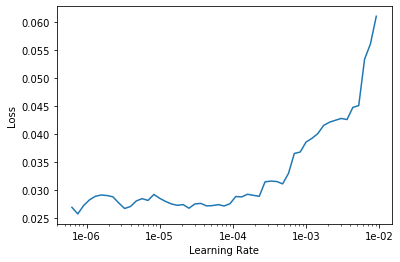

In [30]:
lr_find(learner)
learner.recorder.plot()

In [31]:
lr = slice(1e-06, 1e-04)

In [32]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,dice,time
0,0.027367,0.036389,0.993714,00:28
1,0.027921,0.031845,0.993881,00:29
2,0.025967,0.032240,0.994625,00:29
3,0.024068,0.026606,0.995204,00:31


In [33]:
lr = slice(1e-06, 1e-05)

In [34]:
learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,dice,time
0,0.020424,0.027466,0.995291,00:28
1,0.020824,0.028706,0.995208,00:29
2,0.020130,0.027128,0.995381,00:30
3,0.019479,0.027327,0.995379,00:29


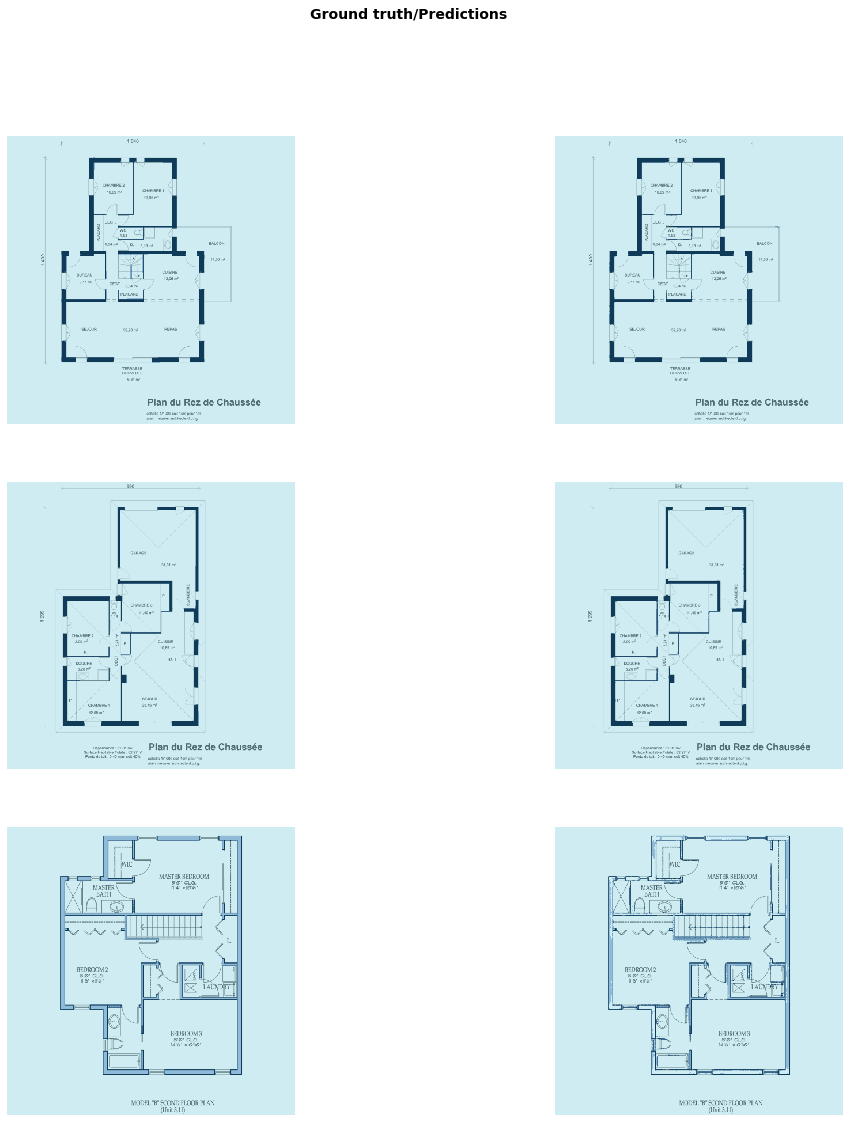

In [37]:
#problem - is superimposed black on black or blue on blue
learner.show_results(rows=3, figsize=(18,18))